In [504]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import wrf
from wrf import (to_np, getvar, smooth2d, get_basemap, cartopy_xlim,
                cartopy_ylim, latlon_coords, interplevel, extract_times)

In [505]:
# Open/Load wrf and obs data
ncfile_wrf = Dataset("../brianjs/MCS_LLJ_study/WRF_3.6.1_3km/wrfout_d01_2015-07-14_1200_UTC_WSM6_YSU.nc")
ncfile_obs = Dataset("../brianjs/MCS_LLJ_study/obs_reflectivity/refc_07_15_2015.nc")

In [506]:
# Get Python variables from wrf and obs variables
time = 17
# WRF-Python Variables
dbz_wrf = getvar(ncfile_wrf,"dbz",time) # Reflectivity
p = getvar(ncfile_wrf,"pressure",time) # Pressure in hPa
z = getvar(ncfile_wrf,"z",time,units="m") # Height in m
ua = getvar(ncfile_wrf,"ua",time) # Zonal component of wind in m/s
va = getvar(ncfile_wrf,"va",time) # Meridional component of wind in m/s
wspd = getvar(ncfile_wrf,"wspd_wdir",time) #Wind Speed & Direction in m/s
rh = getvar(ncfile_wrf,"rh",time) # 2m Relative Humidity as a Percentage
temp = getvar(ncfile_wrf,"temp",time,units='degC') # Temperature in degC
pres = 1013.25 #Sea Level Pressure in hPa
# Obs-Python Variables
dbz_obs = ncfile_obs.variables['REFC_P0_L200_GLL0'][time,:,:] #[time,north-south,east-west
lat_obs = ncfile_obs.variables['lat_0'][:]
lon_obs = ncfile_obs.variables['lon_0'][:]

In [507]:
def rh2qair(rh, temp, p):
    es = 6.112 * np.exp((17.67 * temp) / (temp + 243.5))
    e = (rh / 100) * es
    qair = (0.622 * e) / (p - (0.378 * e)) * 1000
    return(qair)

In [508]:
qair = rh2qair(rh,temp,p) # Units of g/kg
print(qair)
print(np.min(qair))
print(np.max(qair))

<xarray.DataArray (bottom_top: 49, south_north: 532, west_east: 532)>
array([[[  1.060496e+01,   1.079652e+01, ...,   1.714353e+01,   1.719163e+01],
        [  1.066943e+01,   1.084026e+01, ...,   1.715367e+01,   1.716546e+01],
        ..., 
        [  9.009311e+00,   9.114433e+00, ...,   7.936501e+00,   7.965943e+00],
        [  8.988507e+00,   9.063265e+00, ...,   7.830638e+00,   7.842373e+00]],

       [[  1.056416e+01,   1.074748e+01, ...,   1.700684e+01,   1.703732e+01],
        [  1.063353e+01,   1.079311e+01, ...,   1.701856e+01,   1.702015e+01],
        ..., 
        [  8.878312e+00,   8.991250e+00, ...,   7.494976e+00,   7.517532e+00],
        [  8.873666e+00,   8.944552e+00, ...,   7.392919e+00,   7.413420e+00]],

       ..., 
       [[  8.877084e-03,   8.946754e-03, ...,   1.367213e-02,   1.372763e-02],
        [  8.880313e-03,   8.975051e-03, ...,   1.209886e-02,   1.360850e-02],
        ..., 
        [  2.012053e-03,   2.119594e-03, ...,   1.088549e-03,   1.035599e-03],
  

In [509]:
# Create composite reflectivity for wrf (obs is already composite)
dBZ_wrf = np.zeros(dbz_wrf[0,0].shape)
dBZ_wrf = np.max(dbz_wrf, axis=0)
for i in range(len(dbz_wrf[1,:,1])):
    for j in range(len(dbz_wrf[1,1,:])):
        dBZ_wrf[i,j] = np.max(dbz_wrf[:,i,j])

In [510]:
# Interpolate geopotential height, u, v, to 900 hPa
qair_900 = interplevel(qair,p,900)
ht_900 = interplevel(z,p,900)
u_900 = interplevel(ua,p,900)
v_900 = interplevel(va,p,900)
wspd_900 = interplevel(wspd,p,900)

In [511]:
print(qair_900)
print(np.min(qair_900))
print(np.max(qair_900))

<xarray.DataArray 'None_900_hPa' (south_north: 532, west_east: 532)>
array([[       nan,        nan,        nan, ...,  11.412997,  11.535362,
         11.672219],
       [       nan,        nan,        nan, ...,  11.413541,  11.525716,
         11.648241],
       [       nan,        nan,        nan, ...,  11.419207,  11.517664,
         11.629494],
       ..., 
       [       nan,        nan,        nan, ...,   6.336666,   6.329831,
          6.323655],
       [       nan,        nan,        nan, ...,   6.312501,   6.30044 ,
          6.299231],
       [       nan,        nan,        nan, ...,   6.304623,   6.293336,
          6.273115]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -104.032 -104.001 -103.969 ...
    XLAT     (south_north, west_east) float32 31.5773 31.5798 31.5822 ...
    Time     datetime64[ns] 2015-07-15T05:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    level:          900 hPa
    missing_value:  9.969209968

In [512]:
# Smooth reflectivity and geopotential height
smooth_dBZ_wrf = smooth2d(dBZ_wrf, 5)
smooth_dbz_obs = smooth2d(dbz_obs, 5)
smooth_ht = smooth2d(ht_900, 10)
smooth_qair_900 = smooth2d(qair_900, 10)

In [513]:
# Get basemap mapping (& projections)
lats_wrf, lons_wrf = latlon_coords(dbz_wrf)
bm = get_basemap(dbz_wrf)

# Create Figure
fig = plt.figure(figsize=(20,15))
ax_wrfobs = fig.add_subplot(1,2,1)
ax_wrf = fig.add_subplot(2,2,2)
ax_obs = fig.add_subplot(2,2,4)

# Set GeoAxes to projection used by wrf
#ax = plt.axes()

# Convert the lat/lon coordinates to x/y coordinates in the projection space
x_wrf, y_wrf = bm(to_np(lons_wrf),to_np(lats_wrf))

In [514]:
# create x/y shape files for obs reflectivity
lons_obs, lats_obs = np.meshgrid(lon_obs, lat_obs)
x_obs, y_obs = bm(lons_obs,lats_obs)

In [515]:
# Make line contours for wrf and obs dBZ
level = [40]
levels_qair = [8,10,12,14,16,18,20]
#WRF composite reflectivity at 40 dBZ
cs1 = bm.contour(x_wrf,y_wrf,to_np(dBZ_wrf),levels=level,
                 colors='blue',label='WRF Composite Reflectivity',
                 ax=ax_wrfobs)
#Obs composite reflectivity at 40 dBZ
cs2 = bm.contour(x_obs,y_obs,to_np(dbz_obs),levels=level,
                 colors='red',label='Obs Composite Reflectivity',
                 ax=ax_wrfobs)

# Specific Humidity at 900 mb as filled contours
cs3 = bm.contourf(x_wrf,y_wrf,to_np(qair_900), levels=levels_qair,
                  cmap=get_cmap('Greens'),ax=ax_wrfobs)

In [516]:
# Add 900 hPa wind barbs for every 30th data point
# 5 m/s per half line, 10 m/s per line, 50 m/s per flag
bm.barbs(x_wrf[::30,::30], y_wrf[::30,::30],to_np(u_900[::30,::30]),
         to_np(v_900[::30,::30]),length=6,ax=ax_wrfobs,
         barb_increments=dict(half=5,full=10,flag=50))

(<matplotlib.quiver.Barbs at 0x7f549c72feb8>,
 <matplotlib.quiver.Barbs at 0x7f549c77ec18>)

In [517]:
# Add the geographic boundaries/lines
bm.drawcoastlines(linewidth=0.25,ax=ax_wrfobs)
bm.drawstates(linewidth=0.25,ax=ax_wrfobs)
bm.drawcountries(linewidth=0.25,ax=ax_wrfobs)
bm.drawcoastlines(linewidth=0.25,ax=ax_wrf)
bm.drawstates(linewidth=0.25,ax=ax_wrf)
bm.drawcountries(linewidth=0.25,ax=ax_wrf)
bm.drawcoastlines(linewidth=0.25,ax=ax_obs)
bm.drawstates(linewidth=0.25,ax=ax_obs)
bm.drawcountries(linewidth=0.25,ax=ax_obs)

In [518]:
# Plot WRF Composite Reflectivity & Wind Barbs & Water Vapor Mixing Ratio (Specific Humidity)
# Make filled contours for the composite reflectivity
levels = [5,10,15,20,25,30,35,40,45,50,55,60]
cs_wrf1 = bm.contourf(x_wrf, y_wrf, to_np(dBZ_wrf), levels,
            cmap=get_cmap("jet"),ax=ax_wrf)

# Add 900 hPa wind barbs for every 25th data point
# 5 m/s per half line, 10 m/s per line, 50 m/s per flag
bm.barbs(x_wrf[::40,::40], y_wrf[::40,::40],to_np(u_900[::40,::40]),
         to_np(v_900[::40,::40]),length=6,ax=ax_wrf,
         barb_increments=dict(half=5,full=10,flag=50))

(<matplotlib.quiver.Barbs at 0x7f549c927f28>,
 <matplotlib.quiver.Barbs at 0x7f549c042908>)

In [519]:
# Plot Obs Composite Reflectivity
cs_obs = bm.contourf(x_obs,y_obs,to_np(dbz_obs),levels,
                     ax=ax_obs,cmap=get_cmap("jet"))

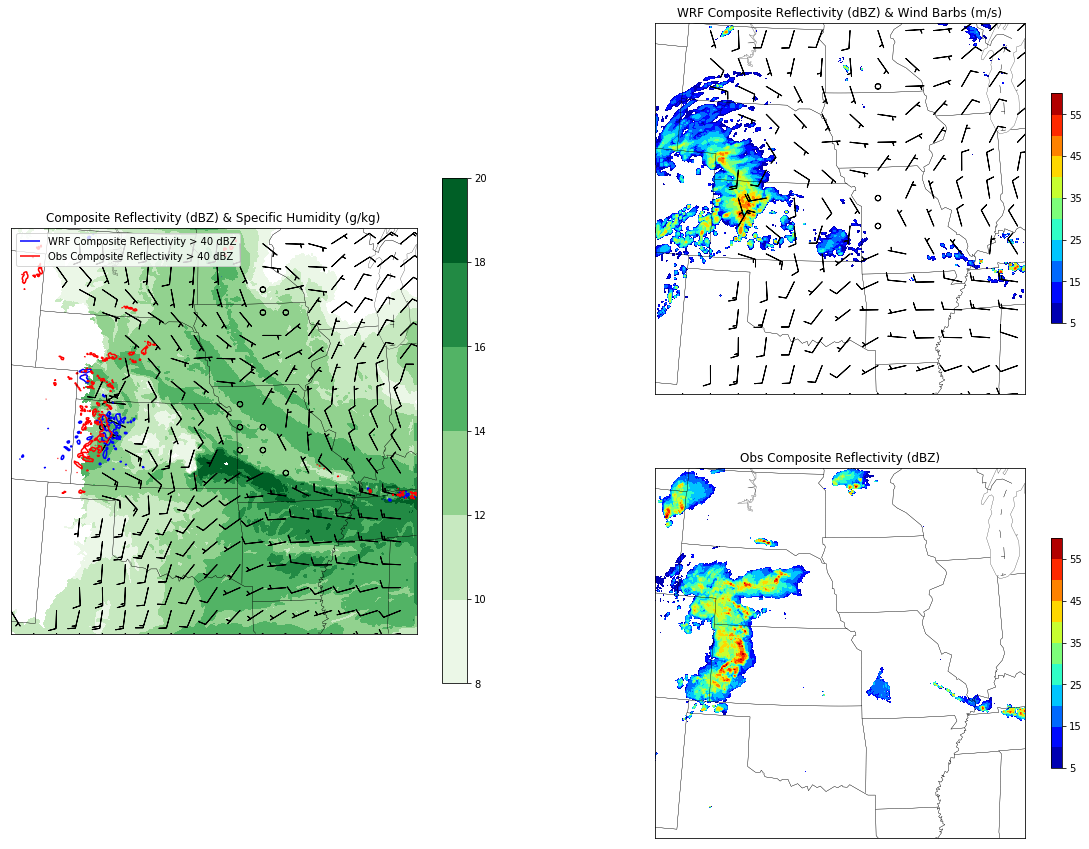

In [520]:
# Create colorbars, legend & titles, then show plot!
# WRF-Obs legend
lines = [ cs1.collections[0], cs2.collections[-1]]
labels = ['WRF Composite Reflectivity > 40 dBZ','Obs Composite Reflectivity > 40 dBZ']
ax_wrfobs.legend(lines, labels, loc='upper left')

# WRF & Obs Colorbar
plt.colorbar(cs_wrf1, ax=ax_wrf, shrink=0.62)
plt.colorbar(cs_obs, ax=ax_obs, shrink=0.62)
plt.colorbar(cs3, ax=ax_wrfobs,shrink=0.62)

# Set titles and show plots!
ax_wrfobs.set_title("Composite Reflectivity (dBZ) & Specific Humidity (g/kg)")
ax_wrf.set_title("WRF Composite Reflectivity (dBZ) & Wind Barbs (m/s)")
ax_obs.set_title("Obs Composite Reflectivity (dBZ)")
plt.show()